In [1]:
import utils
from utils.binaries import *
from utils.plotting import *

In [2]:
utils.setup()

**** MODULES IN GLOBAL NAMESPACE ****

import numpy as np                                       # The fundamental package for scientific computing with Python
import pandas as pd                                      # Easy to use open source data analysis and manipulation tool

import matplotlib.pyplot as plt                          # Comprehensive library for creating beautiful visualizations
import seaborn as sns                                    # Statistical data visualization library based on matplotlib



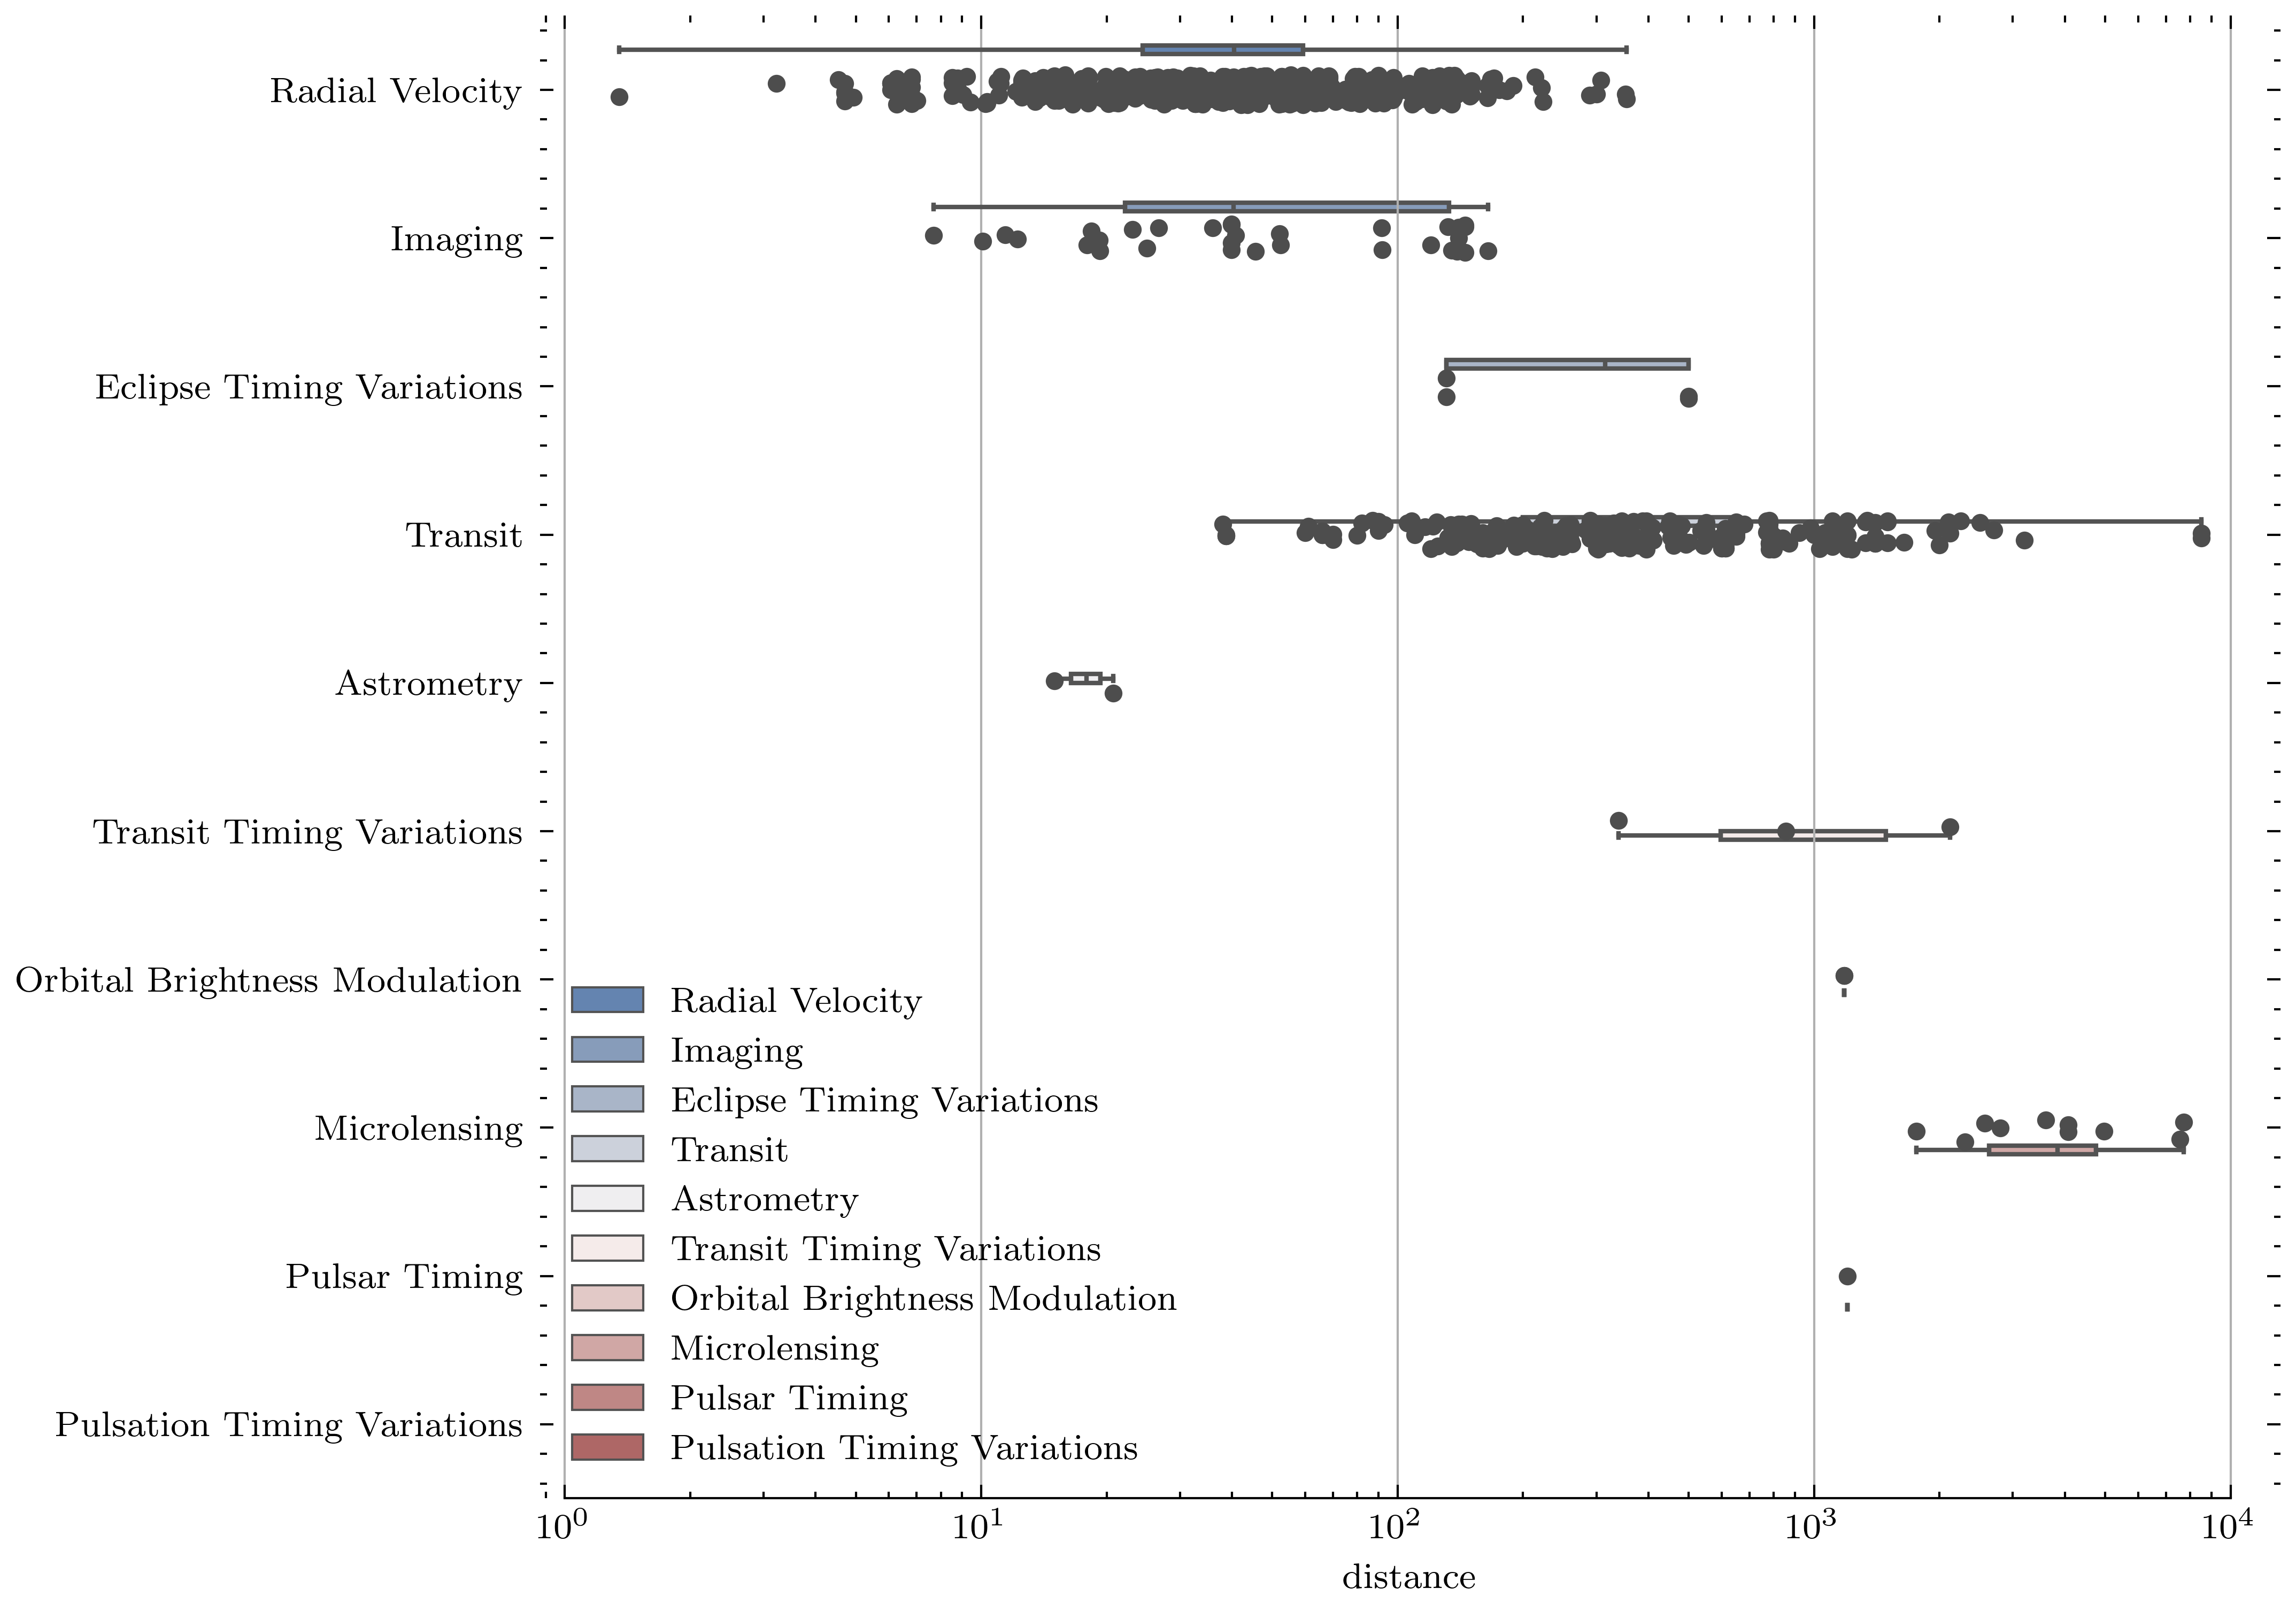

In [3]:
# sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Load the example planets dataset
planets = sns.load_dataset("planets")

# Plot the orbital period with horizontal boxes
sns.boxplot(
    planets, x="distance", y="method", hue="method",
    whis=[0, 100], width=.6, palette="vlag"
)

# Add in points to show each observation
sns.stripplot(planets, x="distance", y="method", size=4, color=".3")

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
